# Cross-validation of embedding-based models

In [1]:
ev = "ev2"

[('CPD-cau-DIS--ctdchemdis', 0.883748508817976), ('signaturizer', 0.8799440536897767), ('CPD-int-GEN--drugbank_pd', 0.8772240075198419), ('CPD-int-GEN--curated_targets', 0.8725548552079843), ('CPD-trt-DIS--ctdchemdis', 0.8689583456573489)]
[('CPD-int-GEN--pharmacogenomic_targets', 0.7502736726874659), ('morgan', 0.6973200441988034), ('grover', 0.6751872162316025), ('rdkit', 0.6586644179428709), ('mordred', 0.4007099368106313)]
[('GEN-has-DOM--interpro', 0.8769412678243682), ('GEN-upr-CLL--gdsc1000_mrna', 0.8751335317414952), ('GEN-ass-DIS--disgenet_curated', 0.8670601200947057), ('esm1b', 0.8614463032450838), ('GEN-ppi-GEN--string', 0.8588184122939913)]
[('GEN-cex-GEN--coexpressdb', 0.8184725384141727), ('GEN-has-CMP--jensencompartmentcurated', 0.8081677517623824), ('uniprot', 0.7923980202874024), ('GEN-ppi-GEN--hi_union', 0.7775362318840578), ('GEN-pab-TIS--hpa_proteome', 0.7623622089330744)]


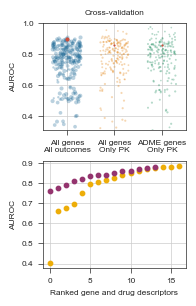

In [ ]:
import os
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import stylia
from stylia.colors.colors import NamedColors

named_colors = NamedColors()
colors = [named_colors.blue, named_colors.orange, named_colors.green]

model_types = ["model_all_outcomes_all_genes", "model_only_pk_all_genes", "model_only_pk_only_adme_genes"]

def load_json(model_folder, fold):
    file = os.path.join(model_folder, "fold_{0}".format(fold), "evaluation.json")
    with open(file, "r") as f:
        return json.load(f)

def load_model_data(model_type):
    model_folder = f"../models/models_pairs_{ev}/{model_type}"
    folds = [i for i in range(5)]
    aurocs = collections.defaultdict(list)
    n_evals = collections.defaultdict(list)
    for fold in folds:
        data = load_json(model_folder, fold)
        for k,v in data.items():
            aurocs[k] += [v["auroc"]]
            n_evals[k] += [v["n_eval"]]
    values = []
    for k,v in data.items():
        values += [(k, np.mean(v["auroc"]), np.mean(v["n_eval"]))]
    return values

def performance_swarmplot(ax, i):
    def sizer(x):
        return np.sqrt(x)/4
    model_type = model_types[i]
    values = load_model_data(model_type)
    for v in values:
        if v[0] == "weighted_average":
            wa = v
    values = [v for v in values if v[0] != "weighted_average" and v[0] != "average"]
    x = [i]*len(values)
    x = np.array([i]*len(values)) + np.random.uniform(-0.3, 0.3, len(values))
    y = np.array([v[1] for v in values])
    z = np.array([sizer(v[2]) for v in values])
    ax.scatter(x, y, s=z, color=colors[i], alpha=0.3, lw=0)
    ax.scatter(i, wa[1], color=named_colors.red, s=sizer(wa[2]), lw=0)

fig, axs = stylia.create_figure(2, 1, width=stylia.TWO_COLUMNS_WIDTH*0.27, height=stylia.TWO_COLUMNS_WIDTH*0.425)
ax = axs.next()
names = ["All genes\nAll outcomes", "All genes\nOnly PK", "ADME genes\nOnly PK"]
for i, n in enumerate(names):
    performance_swarmplot(ax, i)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(names)
ax.set_ylim(0.31, 0.89)
ax.set_xlim(-0.5, 2.5)
stylia.label(ax, title="Cross-validation", ylabel="AUROC", xlabel="")

def best_descriptors(model_type):
    values_ = load_model_data(model_type=model_type)
    values = []
    for v in values_:
        if v[0] != "weighted_average" and v[0] != "average":
            v0, v1 = v[0].split("---")
            values += [(v0, v1, v[1], v[2])]
    cpd_descs = collections.defaultdict(list)
    gen_descs = collections.defaultdict(list)
    for v in values:
        cpd_descs[v[0]] += [v[2]]
        gen_descs[v[1]] += [v[2]]
    cpd_descs = {k:np.percentile(v, 75) for k,v in cpd_descs.items()}
    gen_descs = {k:np.percentile(v, 75) for k,v in gen_descs.items()}
    cpd_descs = sorted(cpd_descs.items(), key=lambda x: x[1], reverse=True)
    gen_descs = sorted(gen_descs.items(), key=lambda x: x[1], reverse=True)
    return cpd_descs, gen_descs

def best_descriptors_plot(ax):
    cpd_desc_synonyms = {
        "CPD-int-GEN--drugbank": "Drug targets",
        "signaturizer": "Chemical Checker",
        "adme": "ADME",
        "rdkit": "Physchem (short)",
        "mordred": "Physchem (long)",
    }
    gen_desc_synonyms = {
        "GEN-ppi-GEN--string": "Functional PPI",
        "esm1b": "ESM sequence embedding",
        "GEN-ass-PWY--reactome": "Pathways",
        "GEN-ppi-GEN--hi_union": "Y2H PPI"
    }
    abcs = "abcdefghi"
    cpd_descs = collections.defaultdict(list)
    gen_descs = collections.defaultdict(list)
    for model_type in [model_types[0], model_types[2]]:
        cpd_descs_, gen_descs_ = best_descriptors(model_type)
        for k,v in cpd_descs_:
            cpd_descs[k] += [v]
        for k,v in gen_descs_:
            gen_descs[k] += [v]
    cpd_descs = {k:np.mean(v) for k,v in cpd_descs.items()}
    gen_descs = {k:np.mean(v) for k,v in gen_descs.items()}
    cpd_descs = sorted(cpd_descs.items(), key=lambda x: x[1], reverse=True)
    gen_descs = sorted(gen_descs.items(), key=lambda x: x[1], reverse=True)
    print(cpd_descs[:5])
    print(cpd_descs[-5:])
    print(gen_descs[:5])
    print(gen_descs[-5:])
    x = np.arange(len(cpd_descs))[::-1]
    y = [v[1] for v in cpd_descs]
    ax.scatter(x, y, color=named_colors.yellow)
    x = np.arange(len(gen_descs))[::-1]
    y = [v[1] for v in gen_descs]
    ax.scatter(x, y, color=named_colors.purple)
    return cpd_descs, gen_descs

ax = axs.next()
best_descriptors_plot(ax=ax)
stylia.label(ax, title="", ylabel="AUROC", xlabel="Ranked gene and drug descriptors")

plt.tight_layout()

stylia.save_figure(f"../assets/cross_validation_performance_{ev}.png")
stylia.save_figure(f"../assets/cross_validation_performance_{ev}.pdf")
